# Spatially resolved post-starburst diagnostic diagram

In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from edge_pydb import EdgeTable
from edge_pydb.plotting import xy2hist
from adjustText import adjust_text
np.seterr(invalid='ignore')
plt.rcParams["scatter.edgecolors"] = 'none'

## Examine the CARMA 7as data

In [2]:
fluxcols = ['Name','ix','iy','rad_arc','flux_Halpha_sm','flux_Hbeta_sm','e_flux_Halpha_sm',
          'flux_[NII]6583_sm','flux_[OIII]5007_sm','EW_Halpha_sm','ZOH_sm','BPT_sm','SF_BPT_sm']
sspcols = ['Name','ix','iy','sigstar_sm']
idxcols = ['Name','ix','iy','Hdel_idx_sm','Hgam_idx_sm']
cocols = ['Name','ix','iy','sigmol','e_sigmol']

fluxtab = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm', cols=fluxcols)
ssptab  = EdgeTable('edge_carma.2d_smo7.hdf5', path='SSP_sm', cols=sspcols)
idxtab  = EdgeTable('edge_carma.2d_smo7.hdf5', path='indices_sm', cols=idxcols)
cotab   = EdgeTable('edge_carma.2d_smo7.hdf5', path='comom_dil', cols=cocols)
globco  = EdgeTable('edge_coflux_smo7.csv', cols=['Name','coSNR4pix_smo7'])
print('Working on 7as data')

Working on 7as data


In [3]:
fluxtab.join(ssptab, keys=['Name', 'ix', 'iy'])
fluxtab.join(idxtab, keys=['Name', 'ix', 'iy'])
fluxtab.join(cotab, keys=['Name', 'ix', 'iy'])
fluxtab.join(globco, keys=['Name'])
print(fluxtab.colnames)

['Name', 'ix', 'iy', 'rad_arc', 'flux_[OIII]5007_sm', 'flux_Hbeta_sm', 'flux_Halpha_sm', 'flux_[NII]6583_sm', 'EW_Halpha_sm', 'e_flux_Halpha_sm', 'BPT_sm', 'SF_BPT_sm', 'ZOH_sm', 'sigstar_sm', 'Hdel_idx_sm', 'Hgam_idx_sm', 'sigmol', 'e_sigmol', 'coSNR4pix_smo7']


In [4]:
fluxtab

Name,ix,iy,rad_arc,flux_[OIII]5007_sm,flux_Hbeta_sm,flux_Halpha_sm,flux_[NII]6583_sm,EW_Halpha_sm,e_flux_Halpha_sm,BPT_sm,SF_BPT_sm,ZOH_sm,sigstar_sm,Hdel_idx_sm,Hgam_idx_sm,sigmol,e_sigmol,coSNR4pix_smo7
,,,arcsec,1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),Angstrom,1e-16 erg / (s cm2),,,dex,solMass / pc2,Angstrom,Angstrom,solMass / pc2,solMass / pc2,
str13,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float64
ARP220,1,1,106.602,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,457.000
ARP220,85,109,75.367,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,457.000
ARP220,85,106,70.942,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,457.000
ARP220,85,103,66.548,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,457.000
ARP220,85,100,62.191,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,457.000
ARP220,85,97,57.879,0.02249415,0.040435996,0.0002042425,0.0074266815,nan,0.016506305,1.0,0,nan,nan,3.1224961,3.071179,nan,nan,457.000
ARP220,85,94,53.624,0.0066889925,0.031980433,0.030790254,0.03624755,nan,0.030352416,0.0,0,nan,12.015831,3.1224961,3.071179,nan,nan,457.000
ARP220,85,91,49.439,0.0012146384,0.007064069,0.035448536,0.031249572,nan,0.03121963,0.0,0,nan,13.817047,3.1224961,3.071179,nan,nan,457.000


## Require 30 CO detected pixels for CO-rich sample

In [5]:
galdet = np.unique(fluxtab['Name'][fluxtab['coSNR4pix_smo7']>30])
print('Selecting',len(galdet),'out of',len(np.unique(fluxtab['Name'])),'galaxies')

Selecting 111 out of 125 galaxies


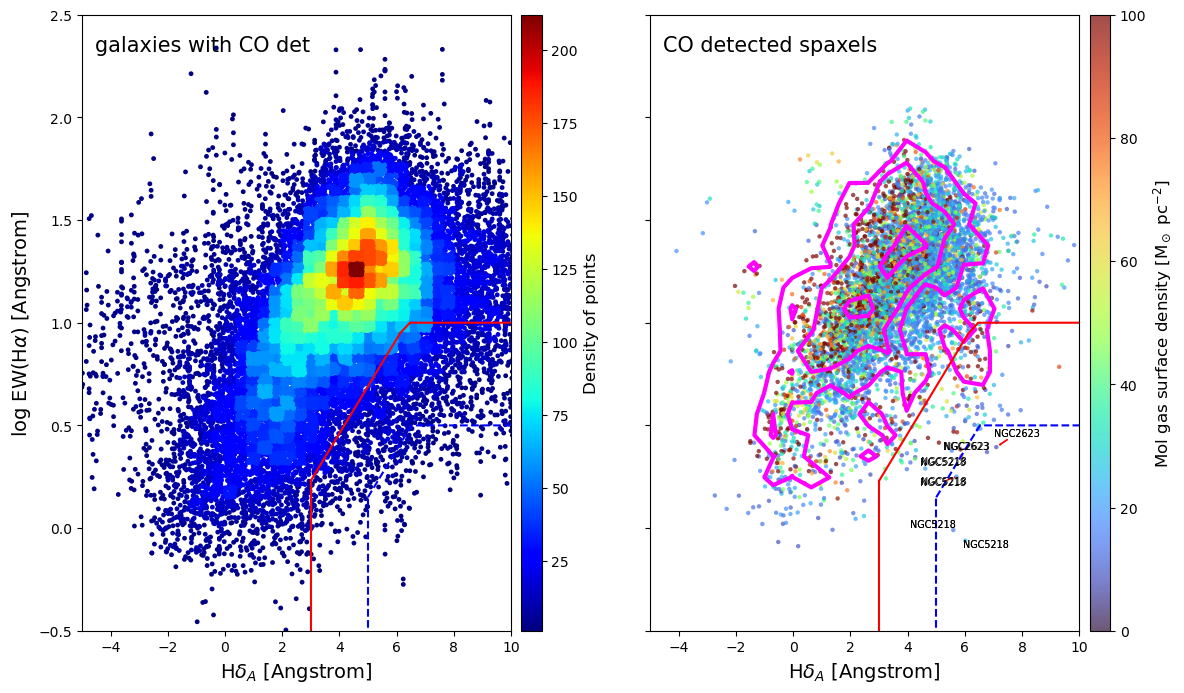

In [6]:
Hdelta = fluxtab['Hdel_idx_sm']
ew_ha = fluxtab['EW_Halpha_sm']
not_nan = (abs(Hdelta)<20) & (abs(ew_ha)>0.1)
localdet = not_nan & (fluxtab['sigmol']>3*fluxtab['e_sigmol'])
globldet = not_nan & (np.isin(fluxtab['Name'],galdet))

fig, axs = plt.subplots(ncols=2,figsize=(14,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)

for i in range(len(axs)):
    if i == 0:
        select = globldet
    else:
        select = localdet
    psb = select & (abs(ew_ha)<10) & (Hdelta>3) & (np.log10(abs(ew_ha))<0.23*Hdelta-0.46)
    if i == 0:
        x_det, y_det, z_det, *hist = xy2hist(Hdelta[globldet], 
                                     np.log10(abs(ew_ha[globldet])), 
                                     log=False)
        sc = axs[i].scatter(x_det, y_det, c=z_det, s=12, cmap='jet')
        axs[i].set_ylabel(r'log EW(H$\alpha$) ['+str(ew_ha.unit)+']',fontsize=14)

    else:
        sc = axs[i].scatter(Hdelta[localdet],np.log10(abs(ew_ha[localdet])),
                       c=fluxtab['sigmol'][localdet],cmap='turbo',s=10,vmin=0,vmax=100,alpha=0.7)
        himol = not_nan & (fluxtab['sigmol'] > 70)
        x_himol, y_himol, z_himol, *hist = xy2hist(Hdelta[himol], np.log10(abs(ew_ha[himol])),
                                                   log=False, bins=[18,18])

        axs[i].contour(hist[0].transpose(),[3.16, 10, 31.6, 100],
               extent=[hist[1].min(),hist[1].max(),
                       hist[2].min(),hist[2].max()],
               colors='magenta',linewidths=3,zorder=2)

    axs[i].set_xlim(-5,10)
    axs[i].set_ylim(-0.5,2.5)
    axs[i].set_xlabel(r'H$\delta_A$ ['+str(Hdelta.unit)+']',fontsize=14)

    if i == 0:
        caption = 'galaxies with CO det'
        cbarlbl = 'Density of points'
    else:
        caption = 'CO detected spaxels'
        cbarlbl = r'Mol gas surface density [M$_\odot$ pc$^{-2}$]'
    axs[i].text(0.03,0.95,caption,ha='left',va='center',
                fontsize=15,transform=axs[i].transAxes)
    # Plot the post-starburst region (Chen+19, 2019MNRAS.489.5709C)
    xmod = np.linspace(3, 20, num=50)
    ymod = 0.23*xmod - 0.46
    ymod[ymod>1] = 1
    axs[i].plot(xmod, ymod, c='r')
    axs[i].plot([xmod[0],xmod[0]], [-1,ymod[0]], c='r')
    # Stricter region
    xmod = np.linspace(5, 20, num=50)
    ymod = 0.23*xmod - 1
    ymod[ymod>0.5] = 0.5
    axs[i].plot(xmod, ymod, c='b', ls='--')
    axs[i].plot([xmod[0],xmod[0]], [-1,ymod[0]], c='b', ls='--')
    psb_select = localdet & (abs(ew_ha)<3) & (Hdelta>5) & (np.log10(abs(ew_ha))<0.23*Hdelta-1)
    xpos = Hdelta[psb_select]
    ypos  = np.log10(abs(ew_ha[psb_select]))
    lbl = fluxtab['Name'][psb_select]
    texts = [plt.text(xpos[i], ypos[i], lbl[i], ha='center', va='center',size='x-small')
             for i in range(len(xpos))]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    cbar = plt.colorbar(sc, ax=axs[i], aspect=30, pad=0.02)
    cbar.set_label(cbarlbl, size=12)


## Strong CO detections in PSB region

In [7]:
psb = localdet & (abs(ew_ha)<10) & (Hdelta>3) & (np.log10(abs(ew_ha))<0.23*Hdelta-0.46)
hipsb = psb & (fluxtab['sigmol']>70)
galname=fluxtab['Name'][hipsb]
df = pd.DataFrame(galname)
pd.set_option('display.max_rows', 1001)
df2 = df['Name'].value_counts().to_frame()
print(f'Loose criterion: {df2.size} galaxies')
print(df2)

psb = localdet & (abs(ew_ha)<3) & (Hdelta>5) & (np.log10(abs(ew_ha))<0.23*Hdelta-1)
hipsb = psb & (fluxtab['sigmol']>70)
galname=fluxtab['Name'][hipsb]
df = pd.DataFrame(galname)
pd.set_option('display.max_rows', 1001)
df2 = df['Name'].value_counts().to_frame()
print(f'\nStrict criterion: {df2.size} galaxies')
print(df2)

Loose criterion: 4 galaxies
          count
Name           
NGC2623      11
ARP220        8
NGC5218       6
UGC09759      6

Strict criterion: 1 galaxies
         count
Name          
NGC5218      1


## CO-rich galaxies with PSB regions

In [8]:
psb2 = globldet & (abs(ew_ha)<10) & (Hdelta>3) & (np.log10(abs(ew_ha))<0.23*Hdelta-0.46)
galname=fluxtab['Name'][psb2]
df = pd.DataFrame(galname)
pd.set_option('display.max_rows', 1001)
df3 = df['Name'].value_counts().to_frame()
print(f'Loose criterion: {df3.size} galaxies')
print(df3)

psb2 = globldet & (abs(ew_ha)<3) & (Hdelta>5) & (np.log10(abs(ew_ha))<0.23*Hdelta-1)
galname=fluxtab['Name'][psb2]
df = pd.DataFrame(galname)
pd.set_option('display.max_rows', 1001)
df3 = df['Name'].value_counts().to_frame()
print(f'\nStrict criterion: {df3.size} galaxies')
print(df3)

Loose criterion: 105 galaxies
              count
Name               
ARP220          147
NGC5394         123
NGC2623         114
NGC5218         106
NGC4470          68
NGC6361          67
NGC5633          62
NGC6155          55
UGC10123         54
NGC6314          44
NGC0523          44
NGC5205          42
NGC6478          42
NGC5614          41
UGC08107         41
UGC03973         41
NGC3687          40
UGC10380         40
NGC0551          38
UGC09759         36
NGC2487          36
NGC0447          36
NGC4711          35
UGC09476         35
NGC4676A         34
NGC5953          33
IC1683           32
NGC2916          32
IC2487           32
NGC5657          31
NGC4211NED02     30
NGC5480          29
IC4566           27
NGC6301          27
NGC6004          26
NGC2253          25
NGC5930          24
UGC05108         24
NGC3811          23
NGC4149          22
NGC6394          22
NGC3303          22
IC0540           21
NGC7738          21
IC2247           21
IC1199           20
IC5376    